In [10]:
import os
import cv2
import torch
import copy
import random
import numbers

import pandas                            as pd
import torch.nn                          as nn
import numpy                             as np
import torch.nn.functional               as F
import torchvision.transforms.functional as F1
import matplotlib.pyplot                 as plt
import torch.optim                       as optim
import albumentations                    as A
import seaborn                           as sns

from albumentations.pytorch  import ToTensorV2
from model.subnet            import ImageConvNet, AudioConvNet
from torch.utils.data        import Dataset, DataLoader
from scipy                   import signal
from scipy.io                import wavfile
from skimage                 import io, transform
from torchvision             import transforms, utils
from sklearn.model_selection import train_test_split
from tqdm                    import tqdm
from sklearn.decomposition   import PCA

In [11]:
#----------------------------------------------------------------------
# Divide the avanible data in the folder named "data" 
# into subset to make training and validation
#----------------------------------------------------------------------
# Parameters: test size to make a partition
# Return: 4 list; videos_train, videos_val, audios_train, audios_val
#-----------------------------------------------------------------------
def generate_train_and_test_sets(test_size = 0.5):

    videos = []
    audios = []
    classes = os.listdir('data/frames/')
    
    for class_ in classes:
        class_videos = os.listdir('data/frames/{}/'.format(class_))
        class_videos = ['{}/'.format(class_) + video_name for video_name in class_videos]
        videos += class_videos
    audios += [video_name[:-4]+'.wav' for video_name in videos]

    videos_train, videos_val, audios_train, audios_val = train_test_split(videos, audios, test_size=test_size, shuffle=True)
    return videos_train, videos_val, audios_train, audios_val
#videos_train, videos_val, audios_train, audios_val = generate_train_and_test_sets(test_size = 0.5)

In [12]:
#----------------------------------------------------------------------
# Visualize the constructed examples for the self supervised task 
#----------------------------------------------------------------------
# Parameters: 
# dataset: instance of the dataset class
# smaples: number of samples to visualize
#-----------------------------------------------------------------------
def data_visualization(dataset, samples):

    data = copy.deepcopy(dataset)
    data.transform = A.Compose([t for t in data.transform if not isinstance(t, (A.Normalize, ToTensorV2))])

    figure, ax = plt.subplots(nrows=2, ncols=samples, figsize=(12, 6))
    for i in range(samples):
        sample      = data[i]
        image       = sample['image']
        spectrogram = sample['spectrogram']
        label       = sample['label']

        ax[0,i].set_title('Label:{}'.format(label))
        ax[0,i].imshow(image)
        ax[0,i].set_axis_off()

        ax[1,i].imshow(spectrogram[0,:,:])
        ax[1,i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [13]:
#----------------------------------------------------------------------
# Custom Dataset class to generate the dataset for self supervised task 
#----------------------------------------------------------------------
# Parameters: 
# root_dir: root dir to search de data
# names_video: list whit the videos names
# names_audio: list whit the audios names
# transforms: composed funtions to make data augmentation
#-----------------------------------------------------------------------
class AudioVisualDataset(Dataset):
    # Start the configuration of the class
    # and adjust the data to do the self supervised task "Audio visual correspondence" 
    def __init__(self, root_dir, names_videos, names_audios, transform=None):
        
        self.videos = names_videos
        self.audios = names_audios
        self.__shuffle__()
        self.root_dir = root_dir
        self.transform = transform

    # For every pair of audio and video, this function create the positive and negative
    # example for the visual correspondence task
    def __shuffle__(self):

        new_videos = []
        new_audios = []
        labels     = []

        for index, video in enumerate(self.videos):
            #positive case
            new_videos.append(video)
            new_audios.append(self.audios[index])
            labels.append(1)
            #negative case 
            rand_index = random.randint(0, len(self.audios)-1)

            while rand_index == index:
                rand_index = random.randint(0, len(self.audios)-1)
            
            new_videos.append(video)
            new_audios.append(self.audios[rand_index])
            labels.append(0)

        self.videos = new_videos
        self.audios = new_audios
        self.labels = labels
    
    # Return the total of elements in the dataset
    def __len__(self):
        return len(self.videos)

    # This funtion is called in every epoch to get one image to construct 
    # the mini batch data 
    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        frames = os.listdir(self.root_dir + '{}/{}/'.format('frames',self.videos[idx]))
        frame_path = frames[len(frames)//2]
        label_class = self.videos[idx].split('/')[1][0]
        vowel = self.videos[idx].split('/')[1][-5]
        frame = io.imread(self.root_dir + '{}/{}/{}/'.format('frames',
                                                             self.videos[idx],
                                                             frame_path))   
        #frame = frame/255
        audio_name = self.audios[idx]
        rate, sample = wavfile.read(self.root_dir + '{}/{}'.format('audio',audio_name))
        
        if sample.shape[1] == 2:
            sample = np.mean(sample,axis=1)

        middle_sample = len(sample)//2
        cur_sample = sample[middle_sample-24000:middle_sample+24000]
        fr, time, spectrogram = signal.spectrogram(cur_sample,fs=48000.,nperseg=480,noverlap=240,nfft=512)

        spectrogram = np.expand_dims(10 * np.log10(spectrogram + 1e-7), 0)
        
        if self.transform:
            frame = self.transform(image = frame)["image"]
        final_data = {'image':frame, 'spectrogram': spectrogram, 'label':self.labels[idx], 'label_class':label_class, 'vowel':vowel}

        return final_data

In [14]:
#----------------------------------------------------------------
# Avolnet architecture according to "The sound of pixels" paper
#----------------------------------------------------------------
class AVOLNet(nn.Module):
    def __init__(self):
        super(AVOLNet, self).__init__()

        # image subnetwork
        self.icn = ImageConvNet()
        self.im_conv5 = nn.Conv2d(512, 128, 1)
        self.im_conv6 = nn.Conv2d(128, 128, 1)

        # audio subnetwork
        self.acn = AudioConvNet()
        self.aud_pool = nn.AdaptiveMaxPool2d(1)
        self.aud_fc1 = nn.Linear(512, 128)
        self.aud_fc2 = nn.Linear(128, 128)

        # fusion network
        self.fus_conv7 = nn.Conv2d(1, 1, 1)
        self.fus_sig = nn.Sigmoid()
        self.fus_pool = nn.AdaptiveMaxPool2d(1)
        # self.fus_fc = nn.Linear(1, 2)
        # self.fus_fc.weight.data[0] = -0.7
        # self.fus_fc.weight.data[1] = 0.7
        # self.fus_fc.bias.data[0] = 1.2
        # self.fus_fc.bias.data[1] = -1.2

    def forward(self, img, aud):
        # image subnetwork
        img = self.icn(img)
        img = self.im_conv5(img)
        img = self.im_conv6(img)

        # audio subnetwork
        aud = self.acn(aud)
        aud = self.aud_pool(aud)
        aud = aud.squeeze(2).squeeze(2)
        aud = F.relu(self.aud_fc1(aud))
        aud = self.aud_fc2(aud)

        # fusion network
        img = img.view(img.size(0), 128, -1)
        aud = aud.view(aud.size(0), 1, -1)
        scalar_prod = torch.bmm(aud, img).view(aud.size(0), 1, 14, 14)
        loc = self.fus_conv7(scalar_prod)
        loc = self.fus_sig(loc)
        out = self.fus_pool(loc).squeeze()
        # out = self.fus_fc(out)

        return out, loc

In [15]:
#----------------------------------------------------------------
# Transformations for training set
#----------------------------------------------------------------
train_transform = A.Compose([
        A.SmallestMaxSize(max_size=224),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.CenterCrop(height=224, width=224),
        #A.Blur(p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
#----------------------------------------------------------------
# Transformations for validation set
#----------------------------------------------------------------
val_transform = A.Compose([
        A.SmallestMaxSize(max_size=224),
        A.CenterCrop(height=224, width=224),
        #A.Blur(p=0.5),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

In [16]:
videos_train, videos_val, audios_train, audios_val = generate_train_and_test_sets(test_size = 0.3)
print(videos_train)

['parkinson/PK4-E.mkv', 'control/C2-I.mkv', 'parkinson/PK4-I.mkv', 'parkinson/PK3-I.mkv', 'parkinson/PK1-I.mkv', 'parkinson/PK3-A.mkv', 'control/C1-A.mkv', 'parkinson/PK4-U.mkv', 'control/C2-A.mkv', 'parkinson/PK3-O.mkv', 'control/C2-E.mkv', 'control/C3-E.mkv', 'control/C1-E.mkv', 'control/C3-O.mkv', 'parkinson/PK1-O.mkv', 'parkinson/PK3-U.mkv', 'control/C1-U.mkv', 'parkinson/PK1-U.mkv', 'parkinson/PK1-A.mkv', 'control/C3-A.mkv', 'parkinson/PK1-E.mkv']


In [17]:
train_data = AudioVisualDataset(root_dir='data/', 
                                names_videos=videos_train,
                                names_audios=audios_train,
                                transform = train_transform
                                )
val_data   = AudioVisualDataset(root_dir='data/',
                                names_videos=videos_val,
                                names_audios=audios_val,
                                transform = val_transform
                                )

print('Training samples: {}'.format(train_data.__len__()))
print('validation samples: {}'.format(val_data.__len__()))

Training samples: 42
validation samples: 18


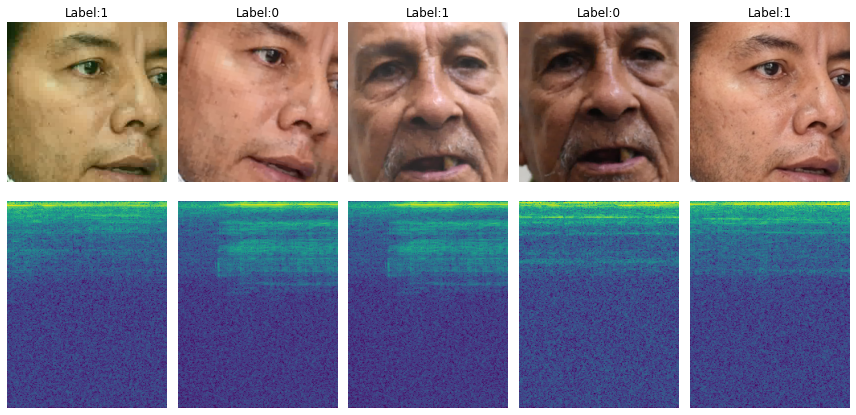

In [18]:
data_visualization(dataset = train_data, samples=5)

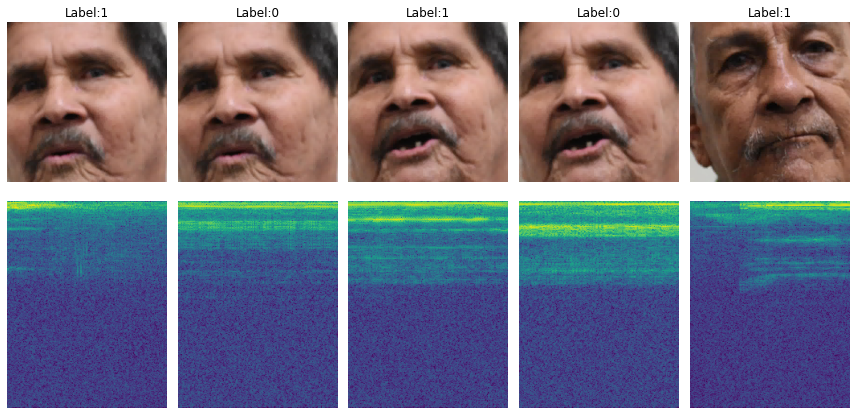

In [19]:
data_visualization(dataset = val_data, samples=5)

In [20]:
#----------------------------------------------------------------------
# Custom train loop 
#----------------------------------------------------------------------
# Parameters: 
# use_cuda: boolean, to use the gpu
# lr: float, learning rate
# epuch: int, number of epuchs in training
# batch_size: int, size of mini batch used in every epuch
#-----------------------------------------------------------------------
def train(use_cuda=True, lr=1e-5, epoch=10, batch_size=5):

    # gpu settings
    if use_cuda and torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using GPU for training:", torch.cuda.get_device_name())
    else:
        if use_cuda:
            print("Failed to find GPU, using CPU instead.")
        device = torch.device("cpu")
    print("Current device:", device)

    results = {'train_loss':[],
               'train_acc' :[],
               'val_loss':[],
               'val_acc' :[],}

    # Instance model
    model = AVOLNet()
    model.to(device)

    # Define loss metric
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # genereate dataset
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    val_dataloader   = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=0)

    #Start training 
    for e in range(epoch):
        train_loss = 0
        train_correct = 0
        train_total = 0
        model.train()
        stream_train = tqdm(train_dataloader)
        for i, data in enumerate(stream_train, start=1):
            # Train stage
            img, aud, label = data['image'].to(device), data['spectrogram'].to(device), data['label'].to(device)
            print(aud.shape)
            out, _ = model(img.float(), aud.float())
            label = label.float()
            loss = criterion(out, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Training metrics
            with torch.no_grad():
                prediction = torch.round(out)
                train_loss += loss.item()
                train_correct += (label == prediction).sum().item()
                train_total += label.size(0)

                train_loss /= 100
                train_acc = train_correct / train_total

                stream_train.set_description("Epoch: {}. T. Loss: {} | Accuracy: {}".format(e+1, round(train_loss,3), round(train_acc,3)))

        # Validation metrics
        val_loss = 0
        val_correct = 0
        val_total = 0
        model.eval()
        stream_val = tqdm(val_dataloader)
        for j, data in enumerate(stream_val, start=1):
            img, aud, label = data['image'].to(device), data['spectrogram'].to(device), data['label'].to(device)
            with torch.no_grad():
                out, _ = model(img.float(), aud.float())
                label = label.float()
                loss = criterion(out, label)
                prediction = torch.round(out)
                val_loss += loss.item()
                val_correct += (label == prediction).sum().item()
                val_total += label.size(0)

                val_loss /= 100
                val_acc = val_correct / val_total

                stream_val.set_description("Epoch: {}. V. Loss: {} | Accuracy: {}".format(e+1, round(val_loss,3), round(val_acc,3)))

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['val_loss'].append(val_loss)
        results['val_acc'].append(val_acc)
        
    return results, model
        #print("Epoch: {}, train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(e+1, train_loss, train_acc, val_loss, val_acc))


In [21]:
results, model = train(epoch=40, batch_size=10)

Using GPU for training: NVIDIA GeForce GTX 1050
Current device: cuda


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 1. T. Loss: 0.007 | Accuracy: 0.7:  20%|██        | 1/5 [00:00<00:01,  2.01it/s]

torch.Size([10, 1, 257, 199])


Epoch: 1. T. Loss: 0.012 | Accuracy: 0.55:  40%|████      | 2/5 [00:00<00:01,  2.42it/s]

torch.Size([10, 1, 257, 199])


Epoch: 1. T. Loss: 0.01 | Accuracy: 0.5:  60%|██████    | 3/5 [00:01<00:00,  2.62it/s]

torch.Size([10, 1, 257, 199])


Epoch: 1. T. Loss: 0.002 | Accuracy: 0.5: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


torch.Size([2, 1, 257, 199])


Epoch: 1. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 2. T. Loss: 0.006 | Accuracy: 0.7:  20%|██        | 1/5 [00:00<00:01,  2.74it/s]

torch.Size([10, 1, 257, 199])


Epoch: 2. T. Loss: 0.011 | Accuracy: 0.5:  40%|████      | 2/5 [00:00<00:01,  2.87it/s]

torch.Size([10, 1, 257, 199])


Epoch: 2. T. Loss: 0.008 | Accuracy: 0.533:  60%|██████    | 3/5 [00:01<00:00,  2.85it/s]

torch.Size([10, 1, 257, 199])


Epoch: 2. T. Loss: 0.013 | Accuracy: 0.5: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


torch.Size([2, 1, 257, 199])


Epoch: 2. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 3. T. Loss: 0.008 | Accuracy: 0.5:  20%|██        | 1/5 [00:00<00:01,  2.70it/s]

torch.Size([10, 1, 257, 199])


Epoch: 3. T. Loss: 0.005 | Accuracy: 0.65:  40%|████      | 2/5 [00:00<00:01,  2.78it/s]

torch.Size([10, 1, 257, 199])


Epoch: 3. T. Loss: 0.009 | Accuracy: 0.567:  60%|██████    | 3/5 [00:01<00:00,  2.84it/s]

torch.Size([10, 1, 257, 199])


Epoch: 3. T. Loss: 0.009 | Accuracy: 0.5: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


torch.Size([2, 1, 257, 199])


Epoch: 3. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.60it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 4. T. Loss: 0.008 | Accuracy: 0.4:  20%|██        | 1/5 [00:00<00:01,  2.82it/s]

torch.Size([10, 1, 257, 199])


Epoch: 4. T. Loss: 0.008 | Accuracy: 0.45:  40%|████      | 2/5 [00:00<00:01,  2.87it/s]

torch.Size([10, 1, 257, 199])


Epoch: 4. T. Loss: 0.009 | Accuracy: 0.433:  60%|██████    | 3/5 [00:01<00:00,  2.84it/s]

torch.Size([10, 1, 257, 199])


Epoch: 4. T. Loss: 0.003 | Accuracy: 0.5: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


torch.Size([2, 1, 257, 199])


Epoch: 4. V. Loss: 0.009 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 5. T. Loss: 0.008 | Accuracy: 0.5:  20%|██        | 1/5 [00:00<00:01,  2.74it/s]

torch.Size([10, 1, 257, 199])


Epoch: 5. T. Loss: 0.009 | Accuracy: 0.4:  40%|████      | 2/5 [00:00<00:01,  2.98it/s]

torch.Size([10, 1, 257, 199])


Epoch: 5. T. Loss: 0.006 | Accuracy: 0.5:  60%|██████    | 3/5 [00:01<00:00,  2.99it/s]

torch.Size([10, 1, 257, 199])


Epoch: 5. T. Loss: 0.007 | Accuracy: 0.5: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


torch.Size([2, 1, 257, 199])


Epoch: 5. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 6. T. Loss: 0.009 | Accuracy: 0.35:  40%|████      | 2/5 [00:00<00:00,  3.01it/s]

torch.Size([10, 1, 257, 199])


Epoch: 6. T. Loss: 0.007 | Accuracy: 0.433:  60%|██████    | 3/5 [00:00<00:00,  3.06it/s]

torch.Size([10, 1, 257, 199])
torch.Size([10, 1, 257, 199])


Epoch: 6. T. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


torch.Size([2, 1, 257, 199])


Epoch: 6. V. Loss: 0.009 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 7. T. Loss: 0.006 | Accuracy: 0.6:  40%|████      | 2/5 [00:00<00:01,  2.95it/s]

torch.Size([10, 1, 257, 199])


Epoch: 7. T. Loss: 0.008 | Accuracy: 0.5:  60%|██████    | 3/5 [00:00<00:00,  3.05it/s]

torch.Size([10, 1, 257, 199])


Epoch: 7. T. Loss: 0.007 | Accuracy: 0.525:  80%|████████  | 4/5 [00:01<00:00,  3.09it/s]

torch.Size([10, 1, 257, 199])


Epoch: 7. T. Loss: 0.01 | Accuracy: 0.5: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


torch.Size([2, 1, 257, 199])


Epoch: 7. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]
Epoch: 8. T. Loss: 0.009 | Accuracy: 0.2:  20%|██        | 1/5 [00:00<00:01,  3.08it/s]

torch.Size([10, 1, 257, 199])


Epoch: 8. T. Loss: 0.006 | Accuracy: 0.45:  40%|████      | 2/5 [00:00<00:00,  3.13it/s]

torch.Size([10, 1, 257, 199])


Epoch: 8. T. Loss: 0.006 | Accuracy: 0.533:  60%|██████    | 3/5 [00:00<00:00,  3.12it/s]

torch.Size([10, 1, 257, 199])


Epoch: 8. T. Loss: 0.007 | Accuracy: 0.5:  80%|████████  | 4/5 [00:01<00:00,  3.13it/s]

torch.Size([10, 1, 257, 199])


Epoch: 8. T. Loss: 0.007 | Accuracy: 0.5: 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


torch.Size([2, 1, 257, 199])


Epoch: 8. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 9. T. Loss: 0.007 | Accuracy: 0.4:  40%|████      | 2/5 [00:00<00:01,  2.96it/s]

torch.Size([10, 1, 257, 199])


Epoch: 9. T. Loss: 0.006 | Accuracy: 0.467:  60%|██████    | 3/5 [00:00<00:00,  3.09it/s]

torch.Size([10, 1, 257, 199])


Epoch: 9. T. Loss: 0.006 | Accuracy: 0.525:  80%|████████  | 4/5 [00:01<00:00,  3.12it/s]

torch.Size([10, 1, 257, 199])


Epoch: 9. T. Loss: 0.007 | Accuracy: 0.524: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


torch.Size([2, 1, 257, 199])


Epoch: 9. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  4.86it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 10. T. Loss: 0.007 | Accuracy: 0.5:  20%|██        | 1/5 [00:00<00:01,  2.66it/s]

torch.Size([10, 1, 257, 199])


Epoch: 10. T. Loss: 0.007 | Accuracy: 0.55:  40%|████      | 2/5 [00:00<00:01,  2.76it/s]

torch.Size([10, 1, 257, 199])


Epoch: 10. T. Loss: 0.006 | Accuracy: 0.533:  60%|██████    | 3/5 [00:01<00:00,  2.78it/s]

torch.Size([10, 1, 257, 199])


Epoch: 10. T. Loss: 0.01 | Accuracy: 0.524: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


torch.Size([2, 1, 257, 199])


Epoch: 10. V. Loss: 0.009 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 11. T. Loss: 0.006 | Accuracy: 0.6:  40%|████      | 2/5 [00:00<00:00,  3.02it/s]

torch.Size([10, 1, 257, 199])


Epoch: 11. T. Loss: 0.007 | Accuracy: 0.567:  60%|██████    | 3/5 [00:00<00:00,  3.08it/s]

torch.Size([10, 1, 257, 199])


Epoch: 11. T. Loss: 0.007 | Accuracy: 0.55:  80%|████████  | 4/5 [00:01<00:00,  3.09it/s]

torch.Size([10, 1, 257, 199])


Epoch: 11. T. Loss: 0.006 | Accuracy: 0.548: 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


torch.Size([2, 1, 257, 199])


Epoch: 11. V. Loss: 0.009 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]
Epoch: 12. T. Loss: 0.006 | Accuracy: 0.8:  20%|██        | 1/5 [00:00<00:01,  3.08it/s]

torch.Size([10, 1, 257, 199])


Epoch: 12. T. Loss: 0.006 | Accuracy: 0.75:  40%|████      | 2/5 [00:00<00:00,  3.16it/s]

torch.Size([10, 1, 257, 199])


Epoch: 12. T. Loss: 0.007 | Accuracy: 0.667:  40%|████      | 2/5 [00:00<00:00,  3.16it/s]

torch.Size([10, 1, 257, 199])


Epoch: 12. T. Loss: 0.007 | Accuracy: 0.6:  80%|████████  | 4/5 [00:01<00:00,  3.09it/s]

torch.Size([10, 1, 257, 199])


Epoch: 12. T. Loss: 0.005 | Accuracy: 0.595: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]


torch.Size([2, 1, 257, 199])


Epoch: 12. V. Loss: 0.01 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]
Epoch: 13. T. Loss: 0.007 | Accuracy: 0.4:  20%|██        | 1/5 [00:00<00:01,  3.17it/s]

torch.Size([10, 1, 257, 199])


Epoch: 13. T. Loss: 0.006 | Accuracy: 0.55:  40%|████      | 2/5 [00:00<00:00,  3.10it/s]

torch.Size([10, 1, 257, 199])


Epoch: 13. T. Loss: 0.007 | Accuracy: 0.533:  60%|██████    | 3/5 [00:00<00:00,  3.12it/s]

torch.Size([10, 1, 257, 199])


Epoch: 13. T. Loss: 0.006 | Accuracy: 0.6:  80%|████████  | 4/5 [00:01<00:00,  3.17it/s]

torch.Size([10, 1, 257, 199])


Epoch: 13. T. Loss: 0.006 | Accuracy: 0.619: 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]


torch.Size([2, 1, 257, 199])


Epoch: 13. V. Loss: 0.007 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.58it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 14. T. Loss: 0.007 | Accuracy: 0.6:  20%|██        | 1/5 [00:00<00:01,  2.88it/s]

torch.Size([10, 1, 257, 199])


Epoch: 14. T. Loss: 0.006 | Accuracy: 0.733:  40%|████      | 2/5 [00:01<00:01,  2.94it/s]

torch.Size([10, 1, 257, 199])


Epoch: 14. T. Loss: 0.006 | Accuracy: 0.733:  60%|██████    | 3/5 [00:01<00:00,  2.90it/s]

torch.Size([10, 1, 257, 199])


Epoch: 14. T. Loss: 0.009 | Accuracy: 0.667: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


torch.Size([2, 1, 257, 199])


Epoch: 14. V. Loss: 0.007 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.58it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 15. T. Loss: 0.005 | Accuracy: 0.7:  20%|██        | 1/5 [00:00<00:01,  2.68it/s]

torch.Size([10, 1, 257, 199])


Epoch: 15. T. Loss: 0.007 | Accuracy: 0.7:  40%|████      | 2/5 [00:00<00:01,  2.81it/s]

torch.Size([10, 1, 257, 199])


Epoch: 15. T. Loss: 0.006 | Accuracy: 0.675:  80%|████████  | 4/5 [00:01<00:00,  2.95it/s]

torch.Size([10, 1, 257, 199])


Epoch: 15. T. Loss: 0.006 | Accuracy: 0.667: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


torch.Size([2, 1, 257, 199])


Epoch: 15. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.64it/s]
Epoch: 16. T. Loss: 0.006 | Accuracy: 0.6:  20%|██        | 1/5 [00:00<00:01,  2.92it/s]

torch.Size([10, 1, 257, 199])


Epoch: 16. T. Loss: 0.006 | Accuracy: 0.7:  40%|████      | 2/5 [00:00<00:00,  3.11it/s]

torch.Size([10, 1, 257, 199])


Epoch: 16. T. Loss: 0.006 | Accuracy: 0.667:  60%|██████    | 3/5 [00:00<00:00,  3.13it/s]

torch.Size([10, 1, 257, 199])


Epoch: 16. T. Loss: 0.007 | Accuracy: 0.675:  80%|████████  | 4/5 [00:01<00:00,  3.16it/s]

torch.Size([10, 1, 257, 199])


Epoch: 16. T. Loss: 0.006 | Accuracy: 0.667: 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]


torch.Size([2, 1, 257, 199])


Epoch: 16. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]
Epoch: 17. T. Loss: 0.006 | Accuracy: 0.4:  20%|██        | 1/5 [00:00<00:01,  3.08it/s]

torch.Size([10, 1, 257, 199])


Epoch: 17. T. Loss: 0.007 | Accuracy: 0.5:  40%|████      | 2/5 [00:00<00:00,  3.16it/s]

torch.Size([10, 1, 257, 199])


Epoch: 17. T. Loss: 0.005 | Accuracy: 0.6:  60%|██████    | 3/5 [00:00<00:00,  3.15it/s]

torch.Size([10, 1, 257, 199])


Epoch: 17. T. Loss: 0.006 | Accuracy: 0.6:  80%|████████  | 4/5 [00:01<00:00,  3.21it/s]

torch.Size([10, 1, 257, 199])


Epoch: 17. T. Loss: 0.006 | Accuracy: 0.595: 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]


torch.Size([2, 1, 257, 199])


Epoch: 17. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]
Epoch: 18. T. Loss: 0.005 | Accuracy: 0.8:  20%|██        | 1/5 [00:00<00:01,  2.99it/s]

torch.Size([10, 1, 257, 199])


Epoch: 18. T. Loss: 0.007 | Accuracy: 0.7:  40%|████      | 2/5 [00:00<00:00,  3.12it/s]

torch.Size([10, 1, 257, 199])


Epoch: 18. T. Loss: 0.006 | Accuracy: 0.733:  60%|██████    | 3/5 [00:00<00:00,  3.14it/s]

torch.Size([10, 1, 257, 199])


Epoch: 18. T. Loss: 0.005 | Accuracy: 0.725:  80%|████████  | 4/5 [00:01<00:00,  3.15it/s]

torch.Size([10, 1, 257, 199])


Epoch: 18. T. Loss: 0.009 | Accuracy: 0.69: 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]


torch.Size([2, 1, 257, 199])


Epoch: 18. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]
Epoch: 19. T. Loss: 0.005 | Accuracy: 0.9:  20%|██        | 1/5 [00:00<00:01,  3.03it/s]

torch.Size([10, 1, 257, 199])


Epoch: 19. T. Loss: 0.006 | Accuracy: 0.7:  40%|████      | 2/5 [00:00<00:00,  3.09it/s]

torch.Size([10, 1, 257, 199])


Epoch: 19. T. Loss: 0.006 | Accuracy: 0.733:  60%|██████    | 3/5 [00:00<00:00,  3.14it/s]

torch.Size([10, 1, 257, 199])


Epoch: 19. T. Loss: 0.006 | Accuracy: 0.725:  80%|████████  | 4/5 [00:01<00:00,  3.11it/s]

torch.Size([10, 1, 257, 199])


Epoch: 19. T. Loss: 0.007 | Accuracy: 0.714: 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]


torch.Size([2, 1, 257, 199])


Epoch: 19. V. Loss: 0.006 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]
Epoch: 20. T. Loss: 0.005 | Accuracy: 0.8:  20%|██        | 1/5 [00:00<00:01,  2.86it/s]

torch.Size([10, 1, 257, 199])


Epoch: 20. T. Loss: 0.006 | Accuracy: 0.8:  40%|████      | 2/5 [00:00<00:01,  2.98it/s]

torch.Size([10, 1, 257, 199])
torch.Size([10, 1, 257, 199])


Epoch: 20. T. Loss: 0.006 | Accuracy: 0.767:  60%|██████    | 3/5 [00:00<00:00,  3.09it/s]

torch.Size([10, 1, 257, 199])


Epoch: 20. T. Loss: 0.007 | Accuracy: 0.714: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


torch.Size([2, 1, 257, 199])


Epoch: 20. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.60it/s]
Epoch: 21. T. Loss: 0.006 | Accuracy: 0.6:  20%|██        | 1/5 [00:00<00:01,  2.82it/s]

torch.Size([10, 1, 257, 199])


Epoch: 21. T. Loss: 0.005 | Accuracy: 0.75:  40%|████      | 2/5 [00:00<00:00,  3.09it/s]

torch.Size([10, 1, 257, 199])


Epoch: 21. T. Loss: 0.005 | Accuracy: 0.733:  60%|██████    | 3/5 [00:00<00:00,  3.04it/s]

torch.Size([10, 1, 257, 199])


Epoch: 21. T. Loss: 0.006 | Accuracy: 0.775:  80%|████████  | 4/5 [00:01<00:00,  3.13it/s]

torch.Size([10, 1, 257, 199])


Epoch: 21. T. Loss: 0.006 | Accuracy: 0.786: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


torch.Size([2, 1, 257, 199])


Epoch: 21. V. Loss: 0.006 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.93it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 22. T. Loss: 0.006 | Accuracy: 0.6:  20%|██        | 1/5 [00:00<00:01,  2.82it/s]

torch.Size([10, 1, 257, 199])


Epoch: 22. T. Loss: 0.005 | Accuracy: 0.75:  40%|████      | 2/5 [00:00<00:01,  2.81it/s]

torch.Size([10, 1, 257, 199])


Epoch: 22. T. Loss: 0.005 | Accuracy: 0.8:  60%|██████    | 3/5 [00:01<00:00,  2.80it/s]

torch.Size([10, 1, 257, 199])


Epoch: 22. T. Loss: 0.008 | Accuracy: 0.786: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


torch.Size([2, 1, 257, 199])


Epoch: 22. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.62it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 23. T. Loss: 0.006 | Accuracy: 0.7:  20%|██        | 1/5 [00:00<00:01,  2.87it/s]

torch.Size([10, 1, 257, 199])


Epoch: 23. T. Loss: 0.006 | Accuracy: 0.733:  60%|██████    | 3/5 [00:00<00:00,  3.10it/s]

torch.Size([10, 1, 257, 199])
torch.Size([10, 1, 257, 199])


Epoch: 23. T. Loss: 0.005 | Accuracy: 0.738: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


torch.Size([2, 1, 257, 199])


Epoch: 23. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 24. T. Loss: 0.005 | Accuracy: 0.8:  20%|██        | 1/5 [00:00<00:01,  2.78it/s]

torch.Size([10, 1, 257, 199])


Epoch: 24. T. Loss: 0.006 | Accuracy: 0.8:  40%|████      | 2/5 [00:01<00:01,  2.90it/s] 

torch.Size([10, 1, 257, 199])


Epoch: 24. T. Loss: 0.005 | Accuracy: 0.85:  80%|████████  | 4/5 [00:01<00:00,  3.06it/s]

torch.Size([10, 1, 257, 199])


Epoch: 24. T. Loss: 0.007 | Accuracy: 0.833: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


torch.Size([2, 1, 257, 199])


Epoch: 24. V. Loss: 0.007 | Accuracy: 0.444: 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]
Epoch: 25. T. Loss: 0.005 | Accuracy: 0.9:  20%|██        | 1/5 [00:00<00:01,  3.20it/s]

torch.Size([10, 1, 257, 199])
torch.Size([10, 1, 257, 199])


Epoch: 25. T. Loss: 0.005 | Accuracy: 0.8:  40%|████      | 2/5 [00:00<00:00,  3.00it/s]

torch.Size([10, 1, 257, 199])


Epoch: 25. T. Loss: 0.006 | Accuracy: 0.8:  60%|██████    | 3/5 [00:00<00:00,  3.02it/s]

torch.Size([10, 1, 257, 199])


Epoch: 25. T. Loss: 0.007 | Accuracy: 0.786: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]


torch.Size([2, 1, 257, 199])


Epoch: 25. V. Loss: 0.007 | Accuracy: 0.444: 100%|██████████| 2/2 [00:00<00:00,  5.66it/s]
Epoch: 26. T. Loss: 0.007 | Accuracy: 0.6:  20%|██        | 1/5 [00:00<00:01,  3.26it/s]

torch.Size([10, 1, 257, 199])


Epoch: 26. T. Loss: 0.005 | Accuracy: 0.75:  40%|████      | 2/5 [00:00<00:00,  3.08it/s]

torch.Size([10, 1, 257, 199])


Epoch: 26. T. Loss: 0.006 | Accuracy: 0.733:  60%|██████    | 3/5 [00:00<00:00,  3.13it/s]

torch.Size([10, 1, 257, 199])


Epoch: 26. T. Loss: 0.005 | Accuracy: 0.775:  80%|████████  | 4/5 [00:01<00:00,  3.16it/s]

torch.Size([10, 1, 257, 199])


Epoch: 26. T. Loss: 0.005 | Accuracy: 0.762: 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]


torch.Size([2, 1, 257, 199])


Epoch: 26. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 27. T. Loss: 0.005 | Accuracy: 0.9:  20%|██        | 1/5 [00:00<00:01,  2.91it/s]

torch.Size([10, 1, 257, 199])


Epoch: 27. T. Loss: 0.006 | Accuracy: 0.85:  40%|████      | 2/5 [00:00<00:01,  2.91it/s]

torch.Size([10, 1, 257, 199])


Epoch: 27. T. Loss: 0.005 | Accuracy: 0.85:  80%|████████  | 4/5 [00:01<00:00,  3.04it/s]

torch.Size([10, 1, 257, 199])


Epoch: 27. T. Loss: 0.007 | Accuracy: 0.833: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


torch.Size([2, 1, 257, 199])


Epoch: 27. V. Loss: 0.007 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]
Epoch: 28. T. Loss: 0.004 | Accuracy: 0.9:  20%|██        | 1/5 [00:00<00:01,  3.02it/s]

torch.Size([10, 1, 257, 199])


Epoch: 28. T. Loss: 0.005 | Accuracy: 0.85:  40%|████      | 2/5 [00:00<00:00,  3.13it/s]

torch.Size([10, 1, 257, 199])


Epoch: 28. T. Loss: 0.006 | Accuracy: 0.8:  60%|██████    | 3/5 [00:00<00:00,  3.13it/s]

torch.Size([10, 1, 257, 199])
torch.Size([10, 1, 257, 199])


Epoch: 28. T. Loss: 0.006 | Accuracy: 0.833: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


torch.Size([2, 1, 257, 199])


Epoch: 28. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]
Epoch: 29. T. Loss: 0.004 | Accuracy: 1.0:  20%|██        | 1/5 [00:00<00:01,  2.86it/s]

torch.Size([10, 1, 257, 199])


Epoch: 29. T. Loss: 0.004 | Accuracy: 0.9:  40%|████      | 2/5 [00:00<00:00,  3.02it/s]

torch.Size([10, 1, 257, 199])


Epoch: 29. T. Loss: 0.004 | Accuracy: 0.867:  60%|██████    | 3/5 [00:00<00:00,  3.09it/s]

torch.Size([10, 1, 257, 199])
torch.Size([10, 1, 257, 199])


Epoch: 29. T. Loss: 0.007 | Accuracy: 0.833: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]


torch.Size([2, 1, 257, 199])


Epoch: 29. V. Loss: 0.009 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 30. T. Loss: 0.004 | Accuracy: 0.9:  20%|██        | 1/5 [00:00<00:01,  2.89it/s]

torch.Size([10, 1, 257, 199])


Epoch: 30. T. Loss: 0.005 | Accuracy: 0.9:  40%|████      | 2/5 [00:00<00:01,  2.85it/s]

torch.Size([10, 1, 257, 199])


Epoch: 30. T. Loss: 0.004 | Accuracy: 0.867:  60%|██████    | 3/5 [00:01<00:00,  2.74it/s]

torch.Size([10, 1, 257, 199])


Epoch: 30. T. Loss: 0.001 | Accuracy: 0.81: 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


torch.Size([2, 1, 257, 199])


Epoch: 30. V. Loss: 0.009 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 31. T. Loss: 0.005 | Accuracy: 0.8:  20%|██        | 1/5 [00:00<00:01,  3.15it/s]

torch.Size([10, 1, 257, 199])


Epoch: 31. T. Loss: 0.003 | Accuracy: 0.867:  60%|██████    | 3/5 [00:00<00:00,  3.04it/s]

torch.Size([10, 1, 257, 199])


Epoch: 31. T. Loss: 0.007 | Accuracy: 0.8:  80%|████████  | 4/5 [00:01<00:00,  3.12it/s]

torch.Size([10, 1, 257, 199])


Epoch: 31. T. Loss: 0.003 | Accuracy: 0.81: 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


torch.Size([2, 1, 257, 199])


Epoch: 31. V. Loss: 0.009 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 32. T. Loss: 0.006 | Accuracy: 0.6:  20%|██        | 1/5 [00:00<00:01,  3.10it/s]

torch.Size([10, 1, 257, 199])


Epoch: 32. T. Loss: 0.005 | Accuracy: 0.65:  40%|████      | 2/5 [00:00<00:01,  2.79it/s]

torch.Size([10, 1, 257, 199])


Epoch: 32. T. Loss: 0.004 | Accuracy: 0.733:  60%|██████    | 3/5 [00:01<00:00,  2.74it/s]

torch.Size([10, 1, 257, 199])


Epoch: 32. T. Loss: 0.006 | Accuracy: 0.762: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


torch.Size([2, 1, 257, 199])


Epoch: 32. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 33. T. Loss: 0.004 | Accuracy: 0.9:  20%|██        | 1/5 [00:00<00:01,  3.04it/s]

torch.Size([10, 1, 257, 199])


Epoch: 33. T. Loss: 0.004 | Accuracy: 0.867:  60%|██████    | 3/5 [00:01<00:00,  2.96it/s]

torch.Size([10, 1, 257, 199])


Epoch: 33. T. Loss: 0.004 | Accuracy: 0.875:  80%|████████  | 4/5 [00:01<00:00,  3.05it/s]

torch.Size([10, 1, 257, 199])


Epoch: 33. T. Loss: 0.005 | Accuracy: 0.881: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]


torch.Size([2, 1, 257, 199])


Epoch: 33. V. Loss: 0.009 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 34. T. Loss: 0.005 | Accuracy: 0.7:  20%|██        | 1/5 [00:00<00:01,  2.83it/s]

torch.Size([10, 1, 257, 199])


Epoch: 34. T. Loss: 0.004 | Accuracy: 0.75:  40%|████      | 2/5 [00:00<00:01,  2.91it/s]

torch.Size([10, 1, 257, 199])


Epoch: 34. T. Loss: 0.004 | Accuracy: 0.8:  60%|██████    | 3/5 [00:01<00:00,  2.91it/s]

torch.Size([10, 1, 257, 199])


Epoch: 34. T. Loss: 0.003 | Accuracy: 0.81: 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


torch.Size([2, 1, 257, 199])


Epoch: 34. V. Loss: 0.007 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 35. T. Loss: 0.004 | Accuracy: 0.8:  20%|██        | 1/5 [00:00<00:01,  2.68it/s]

torch.Size([10, 1, 257, 199])


Epoch: 35. T. Loss: 0.004 | Accuracy: 0.85:  40%|████      | 2/5 [00:00<00:01,  2.84it/s]

torch.Size([10, 1, 257, 199])


Epoch: 35. T. Loss: 0.005 | Accuracy: 0.867:  60%|██████    | 3/5 [00:01<00:00,  2.89it/s]

torch.Size([10, 1, 257, 199])


Epoch: 35. T. Loss: 0.004 | Accuracy: 0.833: 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


torch.Size([2, 1, 257, 199])


Epoch: 35. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 36. T. Loss: 0.003 | Accuracy: 1.0:  20%|██        | 1/5 [00:00<00:01,  2.64it/s]

torch.Size([10, 1, 257, 199])


Epoch: 36. T. Loss: 0.004 | Accuracy: 1.0:  40%|████      | 2/5 [00:00<00:01,  2.80it/s]

torch.Size([10, 1, 257, 199])


Epoch: 36. T. Loss: 0.004 | Accuracy: 0.967:  60%|██████    | 3/5 [00:01<00:00,  2.83it/s]

torch.Size([10, 1, 257, 199])


Epoch: 36. T. Loss: 0.008 | Accuracy: 0.929: 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


torch.Size([2, 1, 257, 199])


Epoch: 36. V. Loss: 0.008 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.65it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 37. T. Loss: 0.002 | Accuracy: 1.0:  20%|██        | 1/5 [00:00<00:01,  2.95it/s]

torch.Size([10, 1, 257, 199])


Epoch: 37. T. Loss: 0.003 | Accuracy: 0.95:  40%|████      | 2/5 [00:00<00:01,  2.95it/s]

torch.Size([10, 1, 257, 199])


Epoch: 37. T. Loss: 0.006 | Accuracy: 0.867:  60%|██████    | 3/5 [00:01<00:00,  2.98it/s]

torch.Size([10, 1, 257, 199])


Epoch: 37. T. Loss: 0.006 | Accuracy: 0.857: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


torch.Size([2, 1, 257, 199])


Epoch: 37. V. Loss: 0.011 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 38. T. Loss: 0.003 | Accuracy: 0.8:  20%|██        | 1/5 [00:00<00:01,  3.04it/s]

torch.Size([10, 1, 257, 199])


Epoch: 38. T. Loss: 0.003 | Accuracy: 0.9:  40%|████      | 2/5 [00:00<00:00,  3.03it/s]

torch.Size([10, 1, 257, 199])


Epoch: 38. T. Loss: 0.005 | Accuracy: 0.85:  80%|████████  | 4/5 [00:01<00:00,  3.07it/s]

torch.Size([10, 1, 257, 199])


Epoch: 38. T. Loss: 0.004 | Accuracy: 0.857: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


torch.Size([2, 1, 257, 199])


Epoch: 38. V. Loss: 0.01 | Accuracy: 0.5: 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 39. T. Loss: 0.003 | Accuracy: 1.0:  20%|██        | 1/5 [00:00<00:01,  2.83it/s]

torch.Size([10, 1, 257, 199])


Epoch: 39. T. Loss: 0.003 | Accuracy: 0.967:  40%|████      | 2/5 [00:00<00:01,  2.93it/s]

torch.Size([10, 1, 257, 199])


Epoch: 39. T. Loss: 0.003 | Accuracy: 0.967:  60%|██████    | 3/5 [00:01<00:00,  3.04it/s]

torch.Size([10, 1, 257, 199])


Epoch: 39. T. Loss: 0.005 | Accuracy: 0.976: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


torch.Size([2, 1, 257, 199])


Epoch: 39. V. Loss: 0.008 | Accuracy: 0.556: 100%|██████████| 2/2 [00:00<00:00,  5.59it/s]
  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([10, 1, 257, 199])


Epoch: 40. T. Loss: 0.003 | Accuracy: 0.9:  20%|██        | 1/5 [00:00<00:01,  2.80it/s]

torch.Size([10, 1, 257, 199])


Epoch: 40. T. Loss: 0.004 | Accuracy: 0.85:  40%|████      | 2/5 [00:00<00:01,  2.95it/s]

torch.Size([10, 1, 257, 199])


Epoch: 40. T. Loss: 0.004 | Accuracy: 0.867:  60%|██████    | 3/5 [00:01<00:00,  3.01it/s]

torch.Size([10, 1, 257, 199])


Epoch: 40. T. Loss: 0.002 | Accuracy: 0.905: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


torch.Size([2, 1, 257, 199])


Epoch: 40. V. Loss: 0.007 | Accuracy: 0.444: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


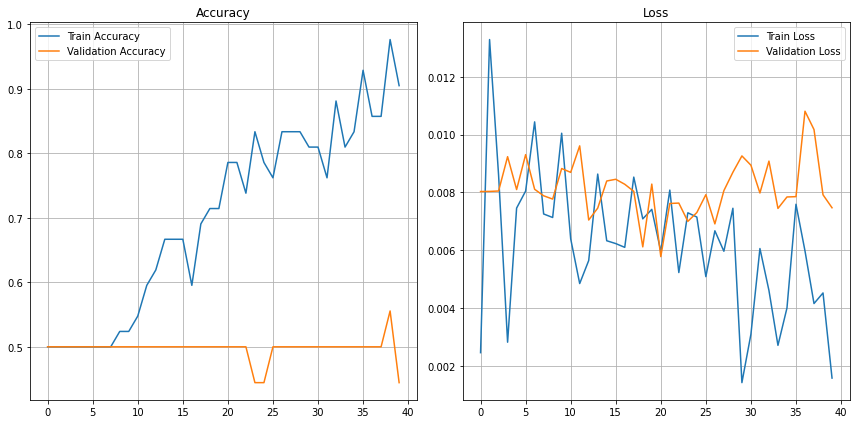

In [22]:
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].set_title('Accuracy')
ax[0].plot(results['train_acc'], label='Train Accuracy')
ax[0].plot(results['val_acc'], label='Validation Accuracy')
ax[0].grid()
ax[0].legend()

ax[1].set_title('Loss')
ax[1].plot(results['train_loss'], label='Train Loss')
ax[1].plot(results['val_loss'], label='Validation Loss')
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

In [23]:
def overlay(img, data):
    # convert heatmap data into ndarray
    #print(type(img[0,0,0]), type(data[0,0]))
    data = np.asarray(data) * 255
    data = np.array(data, dtype=np.uint8)

    #img = np.asarray(img) * 255
    #img = np.array(img, dtype=np.uint8)

    # convert heatmap according to cv2.COLORMAP_HOT
    # reference link: https://docs.opencv.org/2.4/modules/contrib/doc/facerec/colormaps.html
    heatmap = cv2.applyColorMap(data, cv2.COLORMAP_HOT)

    # resize heatmap to be same with img
    heatmapx16 = cv2.resize(heatmap, None, fx=16, fy=16, interpolation=cv2.INTER_AREA)

    # overlay img and heatmap
    dst = cv2.addWeighted(img, 0.5, heatmapx16, 0.5, 0)

    return dst

In [24]:
device = torch.device("cuda")
dataloader = DataLoader(train_data, batch_size=1, shuffle=True, num_workers=0)
predictions = []
images      = []
heat_maps    = []
labels_class = []
vowels = []
for sample in dataloader:

    image = sample['image'].to(device)
    aud   = sample['spectrogram'].to(device)
    label = sample['label'].to(device)
    label_class = sample['label_class'][0]
    vowel = sample['vowel'][0]
    
    if label == 1:

        out, localization = model(image.float(), aud.float())
        localization_np = localization.detach().cpu().numpy()[0,0,:,:]
        image_np = image.permute(0,2,3,1).detach().cpu().numpy()[0,:,:,:]

        predictions.append(localization_np)
        images.append(image_np)
        heat_maps.append(overlay(image_np, localization_np))
        labels_class.append(label_class)
        vowels.append(vowel)

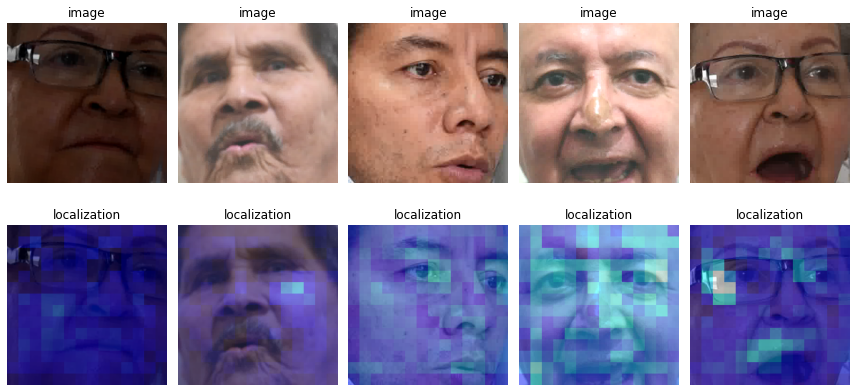

In [25]:
figure, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))

for index, heat_map in enumerate(heat_maps):
    
    if index <5:
        ax[0,index].set_title('image')
        ax[0,index].imshow(images[index])
        ax[0,index].set_axis_off()

        ax[1,index].set_title('localization')
        ax[1,index].imshow(heat_map)
        ax[1,index].set_axis_off()

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='X', ylabel='Y'>

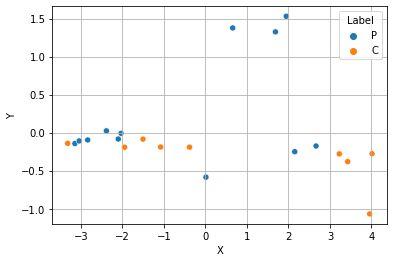

In [26]:
X = []
for localization in predictions:

    X.append(localization.ravel())

pca = PCA(n_components=2)
X_r2 = pca.fit_transform(X)

data_df = pd.DataFrame({'X':X_r2[:,0], 'Y':X_r2[:,1],'Label':labels_class, 'Vowels':vowels})

plt.grid()
sns.scatterplot(data=data_df, x="X", y="Y", hue='Label')

In [27]:
dataloader = DataLoader(val_data, batch_size=1, shuffle=True, num_workers=0)
predictions = []
images      = []
heat_maps    = []
labels_class = []
vowels = []
for sample in dataloader:

    image = sample['image'].to(device)
    aud   = sample['spectrogram'].to(device)
    label = sample['label'].to(device)
    label_class = sample['label_class'][0]
    vowel = sample['vowel'][0]

    if label == 1:

        out, localization = model(image.float(), aud.float())
        localization_np = localization.detach().cpu().numpy()[0,0,:,:]
        image_np = image.permute(0,2,3,1).detach().cpu().numpy()[0,:,:,:]

        predictions.append(localization_np)
        images.append(image_np)
        heat_maps.append(overlay(image_np, localization_np))
        labels_class.append(label_class)
        vowels.append(vowel)

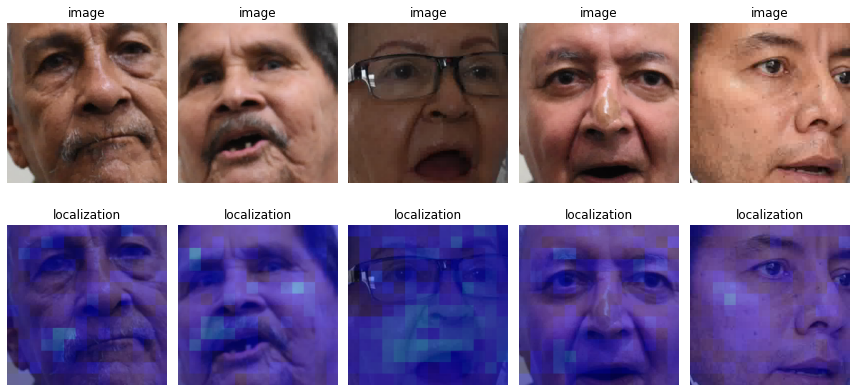

In [28]:
figure, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))

for index, heat_map in enumerate(heat_maps):
    
    if index <5:
        ax[0,index].set_title('image')
        ax[0,index].imshow(images[index])
        ax[0,index].set_axis_off()

        ax[1,index].set_title('localization')
        ax[1,index].imshow(heat_map)
        ax[1,index].set_axis_off()

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='X', ylabel='Y'>

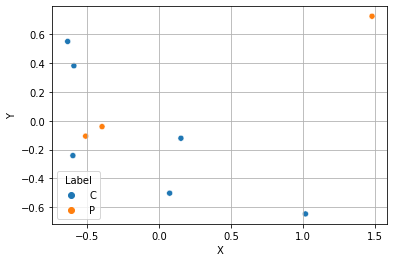

In [29]:
X = []
for localization in predictions:

    X.append(localization.ravel())

pca = PCA(n_components=2)
X_r2 = pca.fit_transform(X)

data_df = pd.DataFrame({'X':X_r2[:,0], 'Y':X_r2[:,1],'Label':labels_class, 'Vowels':vowels})

plt.grid()
sns.scatterplot(data=data_df, x="X", y="Y", hue='Label')